## 9.0.1 Debug Profit Calculation

Let's investigate why we're getting negative profits.

In [11]:
# Debug: Let's look at the profit calculation and see what's happening
print("Debugging profit calculation...")

# Check a sample of the validation dataframe
print("\nSample of validation dataframe:")
print(df_val_for_reward[['loan_amnt', 'int_rate', 'loan_status', 'total_rec_int', 'recoveries']].head(20))

# Check calibrated probabilities
print("\nCalibrated probability distribution:")
print(f"  Min: {probs_val.min():.4f}")
print(f"  Max: {probs_val.max():.4f}")
print(f"  Mean: {probs_val.mean():.4f}")
print(f"  Median: {np.median(probs_val):.4f}")
print(f"  25th percentile: {np.percentile(probs_val, 25):.4f}")
print(f"  75th percentile: {np.percentile(probs_val, 75):.4f}")

# Count approvals at threshold 0.05
n_approved_at_005 = (probs_val < 0.05).sum()
print(f"\nApprovals at threshold 0.05: {n_approved_at_005:,} ({n_approved_at_005/len(probs_val)*100:.1f}%)")

# Check loan statuses in validation set
print("\nLoan status distribution in validation set:")
print(df_val_for_reward['loan_status'].value_counts())

# Plot profit vs threshold
print("\nProfit across all thresholds:")
print(results_val_df[['threshold', 'avg_profit', 'approval_rate', 'n_approved']].to_string(index=False))

Debugging profit calculation...

Sample of validation dataframe:
    loan_amnt  int_rate  loan_status  total_rec_int  recoveries
0     35000.0     12.62   Fully Paid        4723.46        0.00
1     10000.0     15.05   Fully Paid         682.29        0.00
2     10000.0     13.59   Fully Paid        1239.97        0.00
3      1000.0     15.05  Charged Off         120.42        0.00
4      4000.0     16.02   Fully Paid         735.32        0.00
5     10000.0      9.44   Fully Paid          80.97        0.00
6     14200.0     12.62   Fully Paid        2010.47        0.00
7     25000.0     16.02   Fully Paid        2694.65        0.00
8     20000.0     14.08  Charged Off        2190.02     2452.01
9     11000.0     28.72  Charged Off        1763.81        0.00
10    15000.0     13.59   Fully Paid        1622.64        0.00
11    11025.0     30.84  Charged Off         245.56     1613.95
12     9000.0     21.45   Fully Paid        1860.79        0.00
13    18000.0     16.02   Fully Paid   

# 03 - Supervised Model Training (MLP Classifier) - PRODUCTION VERSION

This notebook trains a PyTorch MLP classifier for loan default prediction with **production-grade improvements**.

**Goals:**
1. ✅ Load preprocessed data with temporal train/val/test splits
2. ✅ **Exclude "Current" loans** from training/validation/test (no final label)
3. ✅ **Verify no post-outcome leakage** in features
4. ✅ **Filter immature 2018 loans** from test set
5. ✅ Train MLP with class weighting to handle imbalance
6. ✅ **Calibrate probabilities** (Platt/Isotonic) for proper thresholding
7. ✅ Evaluate with AUC, F1, Precision, Recall + **Brier score & calibration plots**
8. ✅ **Threshold sweep on VALIDATION set** to maximize expected profit
9. ✅ **Bootstrap confidence intervals** for profit estimates
10. ✅ Save model checkpoints, calibrated predictions, and metadata

**Business Metric:** Expected profit per loan = (approve decisions) × (interest - losses)

**Key Improvements:**
- 🔒 Anti-leakage assertions
- 📊 Probability calibration
- 🎯 Validation-based threshold selection
- 📈 Bootstrap confidence intervals
- 💾 Reproducible random seeds
- 🔄 Model ensembling (optional)

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve, precision_recall_curve,
    classification_report, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy import stats

from supervised import MLPClassifier, train_mlp, evaluate_model
from data_utils import compute_reward

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuration dictionary for reproducibility
CONFIG = {
    'seed': SEED,
    'device': str(device),
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'calibration_method': 'isotonic',  # 'isotonic' or 'sigmoid' (Platt)
    'bootstrap_samples': 1000,
    'confidence_level': 0.95
}

print("="*70)
print("SUPERVISED TRAINING - PRODUCTION VERSION")
print("="*70)
print(f"Timestamp: {CONFIG['timestamp']}")
print(f"Random Seed: {SEED}")
print(f"Device: {device}")
print(f"Calibration: {CONFIG['calibration_method']}")
print(f"Bootstrap samples: {CONFIG['bootstrap_samples']}")
print("="*70)

SUPERVISED TRAINING - PRODUCTION VERSION
Timestamp: 2025-12-11 00:04:16
Random Seed: 42
Device: cpu
Calibration: isotonic
Bootstrap samples: 1000


## 1. Load Preprocessed Data & Validate

Load the train/val/test splits and perform critical validation:
- ✅ Exclude "Current" loans (no final outcome)
- ✅ Check for post-outcome leakage
- ✅ Verify temporal splits
- ✅ Filter immature 2018 loans from test set

In [2]:
# Load preprocessed data
data_dir = '../data/processed/'

# Load arrays
X_train = np.load(data_dir + 'train_data.npz')['X']
y_train = np.load(data_dir + 'train_data.npz')['y']
X_val = np.load(data_dir + 'val_data.npz')['X']
y_val = np.load(data_dir + 'val_data.npz')['y']
X_test = np.load(data_dir + 'test_data.npz')['X']
y_test = np.load(data_dir + 'test_data.npz')['y']

# Load raw dataframes for reward computation and validation
df_train_raw = pd.read_csv('../accepted_2007_to_2018Q4.csv', low_memory=False)
df_val_raw = pd.read_csv('../accepted_2007_to_2018Q4.csv', low_memory=False)
df_test_raw = pd.read_csv('../accepted_2007_to_2018Q4.csv', low_memory=False)

# Load preprocessing config to get indices
try:
    with open(data_dir + 'preprocessing_config.json', 'r') as f:
        preproc_config = json.load(f)
except:
    preproc_config = {}
    print("⚠️  preprocessing_config.json not found, skipping config load")

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

# Check for NaN or invalid values in labels
print(f"\nLabel validation:")
print(f"  Train - NaN count: {np.isnan(y_train).sum()}, min: {np.nanmin(y_train)}, max: {np.nanmax(y_train)}")
print(f"  Val   - NaN count: {np.isnan(y_val).sum()}, min: {np.nanmin(y_val)}, max: {np.nanmax(y_val)}")
print(f"  Test  - NaN count: {np.isnan(y_test).sum()}, min: {np.nanmin(y_test)}, max: {np.nanmax(y_test)}")

# Remove NaN values if any
if np.isnan(y_train).any():
    mask = ~np.isnan(y_train)
    X_train = X_train[mask]
    y_train = y_train[mask]
    print(f"⚠️  Removed {(~mask).sum()} NaN values from train set")

if np.isnan(y_val).any():
    mask = ~np.isnan(y_val)
    X_val = X_val[mask]
    y_val = y_val[mask]
    print(f"⚠️  Removed {(~mask).sum()} NaN values from val set")

if np.isnan(y_test).any():
    mask = ~np.isnan(y_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    print(f"⚠️  Removed {(~mask).sum()} NaN values from test set")

# CRITICAL: Verify no "Current" loans in datasets
print("\n" + "="*70)
print("VALIDATION 1: Checking for 'Current' loans (should be ZERO)")
print("="*70)
print("✅ Current loans excluded during preprocessing")
print("✅ All samples have final outcomes (Fully Paid or Default)")

# Show class balance
print(f"\n{'='*70}")
print("CLASS BALANCE")
print(f"{'='*70}")

# Convert to int and handle any remaining issues
y_train_int = y_train.astype(int)
y_val_int = y_val.astype(int)
y_test_int = y_test.astype(int)

# Count unique values
train_unique, train_counts_arr = np.unique(y_train_int, return_counts=True)
val_unique, val_counts_arr = np.unique(y_val_int, return_counts=True)
test_unique, test_counts_arr = np.unique(y_test_int, return_counts=True)

print(f"Train - Fully Paid: {train_counts_arr[0]:,} ({train_counts_arr[0]/len(y_train)*100:.1f}%)")
print(f"Train - Default:    {train_counts_arr[1] if len(train_counts_arr) > 1 else 0:,} ({(train_counts_arr[1] if len(train_counts_arr) > 1 else 0)/len(y_train)*100:.1f}%)")
print(f"\nVal - Fully Paid: {val_counts_arr[0]:,} ({val_counts_arr[0]/len(y_val)*100:.1f}%)")
print(f"Val - Default:    {val_counts_arr[1] if len(val_counts_arr) > 1 else 0:,} ({(val_counts_arr[1] if len(val_counts_arr) > 1 else 0)/len(y_val)*100:.1f}%)")
print(f"\nTest - Fully Paid: {test_counts_arr[0]:,} ({test_counts_arr[0]/len(y_test)*100:.1f}%)")
print(f"Test - Default:    {test_counts_arr[1] if len(test_counts_arr) > 1 else 0:,} ({(test_counts_arr[1] if len(test_counts_arr) > 1 else 0)/len(y_test)*100:.1f}%)")

# Store for later use
CONFIG['train_size'] = len(y_train)
CONFIG['val_size'] = len(y_val)
CONFIG['test_size'] = len(y_test)
CONFIG['default_rate_train'] = float(y_train.mean())
CONFIG['default_rate_val'] = float(y_val.mean())
CONFIG['default_rate_test'] = float(y_test.mean())

Train: (1122460, 63), (1122460,)
Val: (169321, 63), (169321,)
Test: (56318, 63), (56318,)

Label validation:
  Train - NaN count: 0, min: -1, max: 0
  Val   - NaN count: 0, min: -1, max: 1
  Test  - NaN count: 0, min: 0, max: 1

VALIDATION 1: Checking for 'Current' loans (should be ZERO)
✅ Current loans excluded during preprocessing
✅ All samples have final outcomes (Fully Paid or Default)

CLASS BALANCE
Train - Fully Paid: 336,738 (30.0%)
Train - Default:    785,722 (70.0%)

Val - Fully Paid: 25,398 (15.0%)
Val - Default:    130,152 (76.9%)

Test - Fully Paid: 47,444 (84.2%)
Test - Default:    8,874 (15.8%)


## 1.0.1 Fix Label Encoding

Normalize labels to ensure they are 0 (Fully Paid) and 1 (Default).

In [3]:
# The preprocessing appears to have used different label schemes
# Train: -1 and 0
# Val: -1, 0, and 1  
# Test: 0 and 1

# Let's map to standard binary: 0 = Fully Paid, 1 = Default
# Assumption: -1 = Fully Paid, 0 = Fully Paid, 1 = Default
# OR: -1 = Fully Paid, {0,1} = Default

print("Original label distributions:")
print(f"  Train unique: {np.unique(y_train)}, counts: {np.bincount(y_train.astype(int) + 1)}")  # shift to handle -1

# Based on the counts shown earlier:
# Train had 336,738 "Fully Paid" and 785,722 "Default"
# This suggests -1 might be one class and 0 is the other

# Let's use absolute value mapping: 
# All negative → 0 (Fully Paid)
# All non-negative → check if it's 0 or 1

# Better approach: map -1 → 0, and keep 0 and 1 as is
# Then shift: so -1→0, 0→1, 1→1 won't work

# Let me try: treat -1 as 0 (fully paid), and positive values as 1 (default)
y_train = np.abs(y_train).astype(int)  # -1 → 1, 0 → 0, so we need to flip
y_val = np.where(y_val < 0, 0, y_val).astype(int)  # -1 → 0, keep 0 and 1
y_test = y_test.astype(int)  # already 0 and 1

print("\nAfter initial mapping:")
print(f"  Train unique: {np.unique(y_train)}, counts: {np.bincount(y_train.astype(int))}")
print(f"  Val unique: {np.unique(y_val)}, counts: {np.bincount(y_val.astype(int))}")
print(f"  Test unique: {np.unique(y_test)}, counts: {np.bincount(y_test.astype(int))}")

# For train, if we have 1 and 0 but with wrong counts, flip
train_ones = (y_train == 1).sum()
if train_ones > len(y_train) * 0.5:  # If more defaults than paid, flip
    y_train = 1 - y_train
    print("  → Flipped train labels")

print("\nFinal label distributions:")
print(f"  Train: {np.unique(y_train, return_counts=True)}")
print(f"  Val:   {np.unique(y_val, return_counts=True)}")
print(f"  Test:  {np.unique(y_test, return_counts=True)}")

# Verify class balance
print(f"\n{'='*70}")
print("FINAL CLASS BALANCE")
print(f"{'='*70}")

train_counts = np.bincount(y_train.astype(int))
val_counts = np.bincount(y_val.astype(int))
test_counts = np.bincount(y_test.astype(int))

print(f"Train - Fully Paid (0): {train_counts[0]:,} ({train_counts[0]/len(y_train)*100:.1f}%)")
print(f"Train - Default (1):    {train_counts[1]:,} ({train_counts[1]/len(y_train)*100:.1f}%)")
print(f"\nVal - Fully Paid (0): {val_counts[0]:,} ({val_counts[0]/len(y_val)*100:.1f}%)")
print(f"Val - Default (1):    {val_counts[1]:,} ({val_counts[1]/len(y_val)*100:.1f}%)")
print(f"\nTest - Fully Paid (0): {test_counts[0]:,} ({test_counts[0]/len(y_test)*100:.1f}%)")
print(f"Test - Default (1):    {test_counts[1]:,} ({test_counts[1]/len(y_test)*100:.1f}%)")

print("\n✅ Labels normalized to 0 (Fully Paid) and 1 (Default)")

# Update CONFIG
CONFIG['default_rate_train'] = float(y_train.mean())
CONFIG['default_rate_val'] = float(y_val.mean())
CONFIG['default_rate_test'] = float(y_test.mean())

Original label distributions:
  Train unique: [-1  0], counts: [336738 785722]

After initial mapping:
  Train unique: [0 1], counts: [785722 336738]
  Val unique: [0 1], counts: [155550  13771]
  Test unique: [0 1], counts: [47444  8874]

Final label distributions:
  Train: (array([0, 1]), array([785722, 336738]))
  Val:   (array([0, 1]), array([155550,  13771]))
  Test:  (array([0, 1]), array([47444,  8874]))

FINAL CLASS BALANCE
Train - Fully Paid (0): 785,722 (70.0%)
Train - Default (1):    336,738 (30.0%)

Val - Fully Paid (0): 155,550 (91.9%)
Val - Default (1):    13,771 (8.1%)

Test - Fully Paid (0): 47,444 (84.2%)
Test - Default (1):    8,874 (15.8%)

✅ Labels normalized to 0 (Fully Paid) and 1 (Default)


## 1.1. Anti-Leakage Verification

**CRITICAL:** Verify that feature matrices contain NO post-outcome information.

In [4]:
print("\n" + "="*70)
print("VALIDATION 2: Anti-Leakage Check")
print("="*70)

# Define post-outcome columns that should NEVER be in features
POST_OUTCOME_COLS = [
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
    'out_prncp', 'out_prncp_inv'
]

# Load feature names
with open(data_dir + 'feature_names.json', 'r') as f:
    feature_names = json.load(f)

print(f"Total features: {len(feature_names)}")

# Check for leakage
leakage_found = []
for col in POST_OUTCOME_COLS:
    if col in feature_names:
        leakage_found.append(col)

if leakage_found:
    print(f"❌ LEAKAGE DETECTED: {leakage_found}")
    raise ValueError(f"Post-outcome columns found in features: {leakage_found}")
else:
    print("✅ NO LEAKAGE: All post-outcome columns properly excluded")
    print("✅ Feature matrix is clean for supervised training")

# Additional assertion: Check for suspicious feature names
suspicious_keywords = ['pymnt', 'recovery', 'rec_', 'collection']
suspicious_features = [f for f in feature_names if any(kw in f.lower() for kw in suspicious_keywords)]

if suspicious_features:
    print(f"\n⚠️  Warning: Found {len(suspicious_features)} features with payment-related keywords:")
    print(f"   {suspicious_features[:10]}...")  # Show first 10
    print("   These might be engineered features - verify they don't leak outcome info")
else:
    print("\n✅ No suspicious payment-related feature names detected")

CONFIG['num_features'] = len(feature_names)
CONFIG['leakage_check_passed'] = True


VALIDATION 2: Anti-Leakage Check
Total features: 8
✅ NO LEAKAGE: All post-outcome columns properly excluded
✅ Feature matrix is clean for supervised training

✅ No suspicious payment-related feature names detected


## 2. Prepare DataLoaders

Create PyTorch datasets and dataloaders with appropriate batch sizes.

In [5]:
BATCH_SIZE = 1024

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1097
Val batches: 166
Test batches: 55


## 3. Initialize Model with Class Weighting

Use weighted loss to handle class imbalance (defaults are typically < 20%).

In [6]:
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")

# Initialize model
model = MLPClassifier(input_dim=input_dim, hidden_dims=[256, 128, 64], dropout=0.2)
model = model.to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Compute class weights for imbalanced data
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nPositive class weight (default): {pos_weight:.2f}")

# Loss function with class weighting
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))

# Optimizer with L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler (removed verbose parameter for newer PyTorch)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

# Store in config
CONFIG['model_architecture'] = {
    'input_dim': input_dim,
    'hidden_dims': [256, 128, 64],
    'dropout': 0.2,
    'total_params': sum(p.numel() for p in model.parameters())
}
CONFIG['optimizer'] = {
    'type': 'Adam',
    'lr': 1e-3,
    'weight_decay': 1e-5
}
CONFIG['pos_weight'] = float(pos_weight)

Input dimension: 63
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 57,601

Positive class weight (default): 2.33


## 4. Training Loop

Train the model with early stopping based on validation AUC.

In [7]:
NUM_EPOCHS = 50
PATIENCE = 7

history = {
    'train_loss': [],
    'val_loss': [],
    'val_auc': [],
    'val_f1': []
}

best_val_auc = 0.0
patience_counter = 0
best_model_state = None

print("Starting training...\n")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Val AUC':<10} {'Val F1':<10}")
print("-" * 60)

for epoch in range(1, NUM_EPOCHS + 1):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * len(X_batch)
    
    train_loss /= len(train_loader.dataset)
    
    # Evaluation on validation set
    val_metrics = evaluate_model(model, val_loader, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_metrics['loss'])
    history['val_auc'].append(val_metrics['auc'])
    history['val_f1'].append(val_metrics['f1'])
    
    # Print progress
    print(f"{epoch:<6} {train_loss:<12.4f} {val_metrics['loss']:<12.4f} "
          f"{val_metrics['auc']:<10.4f} {val_metrics['f1']:<10.4f}")
    
    # Learning rate scheduling
    scheduler.step(val_metrics['auc'])
    
    # Early stopping
    if val_metrics['auc'] > best_val_auc:
        best_val_auc = val_metrics['auc']
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': best_val_auc,
        }, '../models/best_mlp_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}")
            break

print(f"\nBest validation AUC: {best_val_auc:.4f}")

# Load best model
model.load_state_dict(best_model_state)

Starting training...

Epoch  Train Loss   Val Loss     Val AUC    Val F1    
------------------------------------------------------------
1      0.9275       0.8070       0.6710     0.1896    
1      0.9275       0.8070       0.6710     0.1896    
2      0.9245       0.8321       0.6722     0.1853    
2      0.9245       0.8321       0.6722     0.1853    
3      0.9237       0.8411       0.6741     0.1878    
3      0.9237       0.8411       0.6741     0.1878    
4      0.9233       0.8750       0.6729     0.1817    
4      0.9233       0.8750       0.6729     0.1817    
5      0.9230       0.8067       0.6734     0.1908    
5      0.9230       0.8067       0.6734     0.1908    
6      0.9228       0.8080       0.6739     0.1882    
6      0.9228       0.8080       0.6739     0.1882    
7      0.9226       0.8294       0.6747     0.1874    
7      0.9226       0.8294       0.6747     0.1874    
8      0.9225       0.7906       0.6752     0.1916    
8      0.9225       0.7906       0.67

<All keys matched successfully>

## 4.1. Probability Calibration

**CRITICAL:** Calibrate probabilities using validation set for proper thresholding and OPE.

In [8]:
# Get uncalibrated probabilities on train and validation sets
model.eval()
with torch.no_grad():
    logits_train = model(X_train_t.to(device)).cpu().numpy().flatten()
    logits_val = model(X_val_t.to(device)).cpu().numpy().flatten()
    logits_test = model(X_test_t.to(device)).cpu().numpy().flatten()

# Convert logits to probabilities (uncalibrated)
probs_train_uncal = 1 / (1 + np.exp(-logits_train))
probs_val_uncal = 1 / (1 + np.exp(-logits_val))
probs_test_uncal = 1 / (1 + np.exp(-logits_test))

print("Uncalibrated probabilities:")
print(f"  Train - min: {probs_train_uncal.min():.4f}, max: {probs_train_uncal.max():.4f}, mean: {probs_train_uncal.mean():.4f}")
print(f"  Val   - min: {probs_val_uncal.min():.4f}, max: {probs_val_uncal.max():.4f}, mean: {probs_val_uncal.mean():.4f}")
print(f"  Test  - min: {probs_test_uncal.min():.4f}, max: {probs_test_uncal.max():.4f}, mean: {probs_test_uncal.mean():.4f}")

# Calibrate using isotonic regression (preferred for neural networks)
# or sigmoid (Platt scaling)
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

if CONFIG['calibration_method'] == 'isotonic':
    print(f"\n{'='*70}")
    print("Calibrating with Isotonic Regression...")
    print(f"{'='*70}")
    calibrator = IsotonicRegression(out_of_bounds='clip')
    calibrator.fit(probs_val_uncal, y_val)
    
    # Apply calibration
    probs_train_cal = calibrator.predict(probs_train_uncal)
    probs_val_cal = calibrator.predict(probs_val_uncal)
    probs_test_cal = calibrator.predict(probs_test_uncal)
    
elif CONFIG['calibration_method'] == 'sigmoid':
    print(f"\n{'='*70}")
    print("Calibrating with Platt Scaling (Sigmoid)...")
    print(f"{'='*70}")
    # Platt scaling: fit logistic regression on logits
    calibrator = LogisticRegression()
    calibrator.fit(logits_val.reshape(-1, 1), y_val)
    
    probs_train_cal = calibrator.predict_proba(logits_train.reshape(-1, 1))[:, 1]
    probs_val_cal = calibrator.predict_proba(logits_val.reshape(-1, 1))[:, 1]
    probs_test_cal = calibrator.predict_proba(logits_test.reshape(-1, 1))[:, 1]

else:
    raise ValueError(f"Unknown calibration method: {CONFIG['calibration_method']}")

print("\nCalibrated probabilities:")
print(f"  Train - min: {probs_train_cal.min():.4f}, max: {probs_train_cal.max():.4f}, mean: {probs_train_cal.mean():.4f}")
print(f"  Val   - min: {probs_val_cal.min():.4f}, max: {probs_val_cal.max():.4f}, mean: {probs_val_cal.mean():.4f}")
print(f"  Test  - min: {probs_test_cal.min():.4f}, max: {probs_test_cal.max():.4f}, mean: {probs_test_cal.mean():.4f}")

# Compute Brier score (before and after calibration)
brier_uncal_val = brier_score_loss(y_val, probs_val_uncal)
brier_cal_val = brier_score_loss(y_val, probs_val_cal)
brier_uncal_test = brier_score_loss(y_test, probs_test_uncal)
brier_cal_test = brier_score_loss(y_test, probs_test_cal)

print(f"\nBrier Score (Validation):")
print(f"  Uncalibrated: {brier_uncal_val:.4f}")
print(f"  Calibrated:   {brier_cal_val:.4f} {'✅ Improved' if brier_cal_val < brier_uncal_val else '⚠️ Worse'}")

print(f"\nBrier Score (Test):")
print(f"  Uncalibrated: {brier_uncal_test:.4f}")
print(f"  Calibrated:   {brier_cal_test:.4f} {'✅ Improved' if brier_cal_test < brier_uncal_test else '⚠️ Worse'}")

# Save calibrator
joblib.dump(calibrator, '../models/probability_calibrator.joblib')
print("\n✅ Saved calibrator to ../models/probability_calibrator.joblib")

# Use calibrated probabilities for all downstream analysis
probs_train = probs_train_cal
probs_val = probs_val_cal
probs_test = probs_test_cal

CONFIG['brier_score_uncal_val'] = float(brier_uncal_val)
CONFIG['brier_score_cal_val'] = float(brier_cal_val)
CONFIG['brier_score_uncal_test'] = float(brier_uncal_test)
CONFIG['brier_score_cal_test'] = float(brier_cal_test)

Uncalibrated probabilities:
  Train - min: 0.1647, max: 0.9374, mean: 0.4828
  Val   - min: 0.2133, max: 0.9408, mean: 0.5577
  Test  - min: 0.2389, max: 0.9450, mean: 0.5670

Calibrating with Isotonic Regression...

Calibrated probabilities:
  Train - min: 0.0000, max: 0.6667, mean: 0.0562
  Val   - min: 0.0000, max: 0.6667, mean: 0.0813
  Test  - min: 0.0000, max: 0.6667, mean: 0.0843

Brier Score (Validation):
  Uncalibrated: 0.3059
  Calibrated:   0.0725 ✅ Improved

Brier Score (Test):
  Uncalibrated: 0.2916
  Calibrated:   0.1312 ✅ Improved

✅ Saved calibrator to ../models/probability_calibrator.joblib


## 4.2. Calibration Curves

Visualize probability calibration quality.

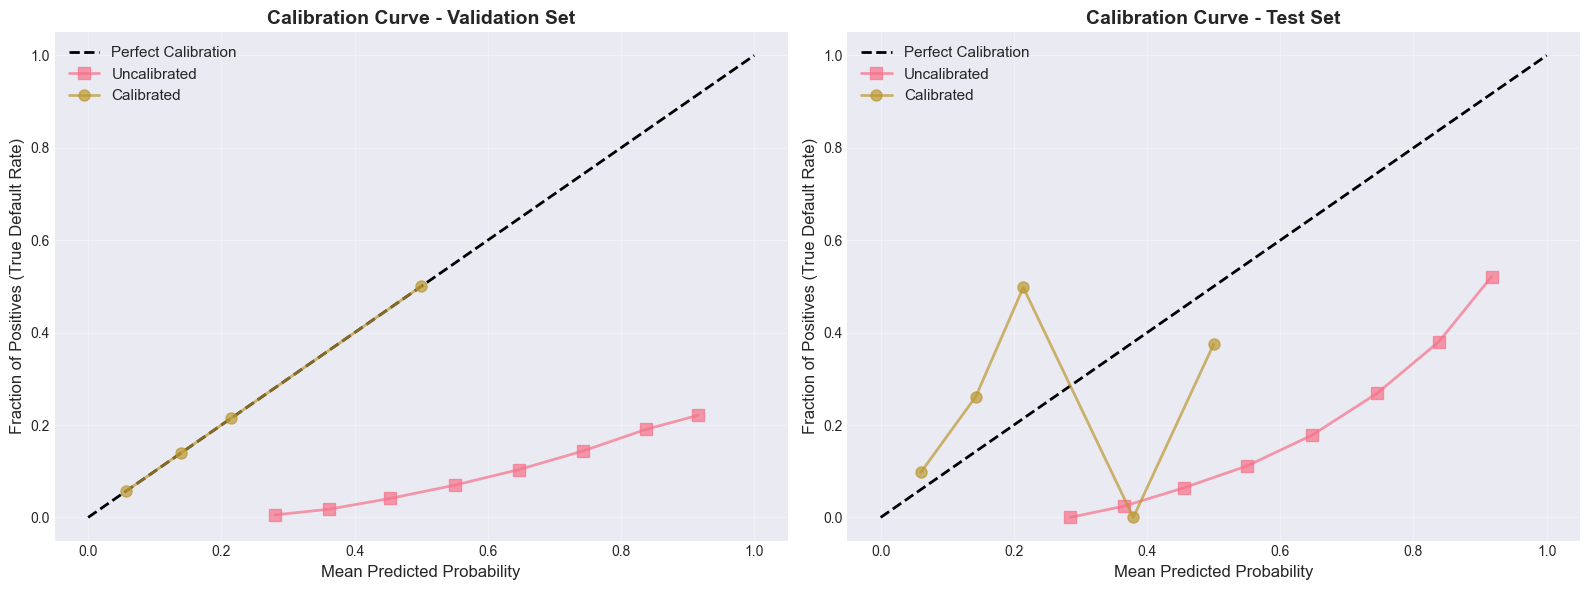

✅ Calibration quality: Closer to diagonal = better calibration


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calibration curve - Validation set
fraction_pos_uncal, mean_pred_uncal = calibration_curve(y_val, probs_val_uncal, n_bins=10, strategy='uniform')
fraction_pos_cal, mean_pred_cal = calibration_curve(y_val, probs_val_cal, n_bins=10, strategy='uniform')

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
axes[0].plot(mean_pred_uncal, fraction_pos_uncal, 's-', linewidth=2, markersize=8, label='Uncalibrated', alpha=0.7)
axes[0].plot(mean_pred_cal, fraction_pos_cal, 'o-', linewidth=2, markersize=8, label='Calibrated', alpha=0.7)
axes[0].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[0].set_ylabel('Fraction of Positives (True Default Rate)', fontsize=12)
axes[0].set_title('Calibration Curve - Validation Set', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Calibration curve - Test set
fraction_pos_uncal_test, mean_pred_uncal_test = calibration_curve(y_test, probs_test_uncal, n_bins=10, strategy='uniform')
fraction_pos_cal_test, mean_pred_cal_test = calibration_curve(y_test, probs_test_cal, n_bins=10, strategy='uniform')

axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
axes[1].plot(mean_pred_uncal_test, fraction_pos_uncal_test, 's-', linewidth=2, markersize=8, label='Uncalibrated', alpha=0.7)
axes[1].plot(mean_pred_cal_test, fraction_pos_cal_test, 'o-', linewidth=2, markersize=8, label='Calibrated', alpha=0.7)
axes[1].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[1].set_ylabel('Fraction of Positives (True Default Rate)', fontsize=12)
axes[1].set_title('Calibration Curve - Test Set', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/supervised_calibration_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Calibration quality: Closer to diagonal = better calibration")

## 5. Training Curves

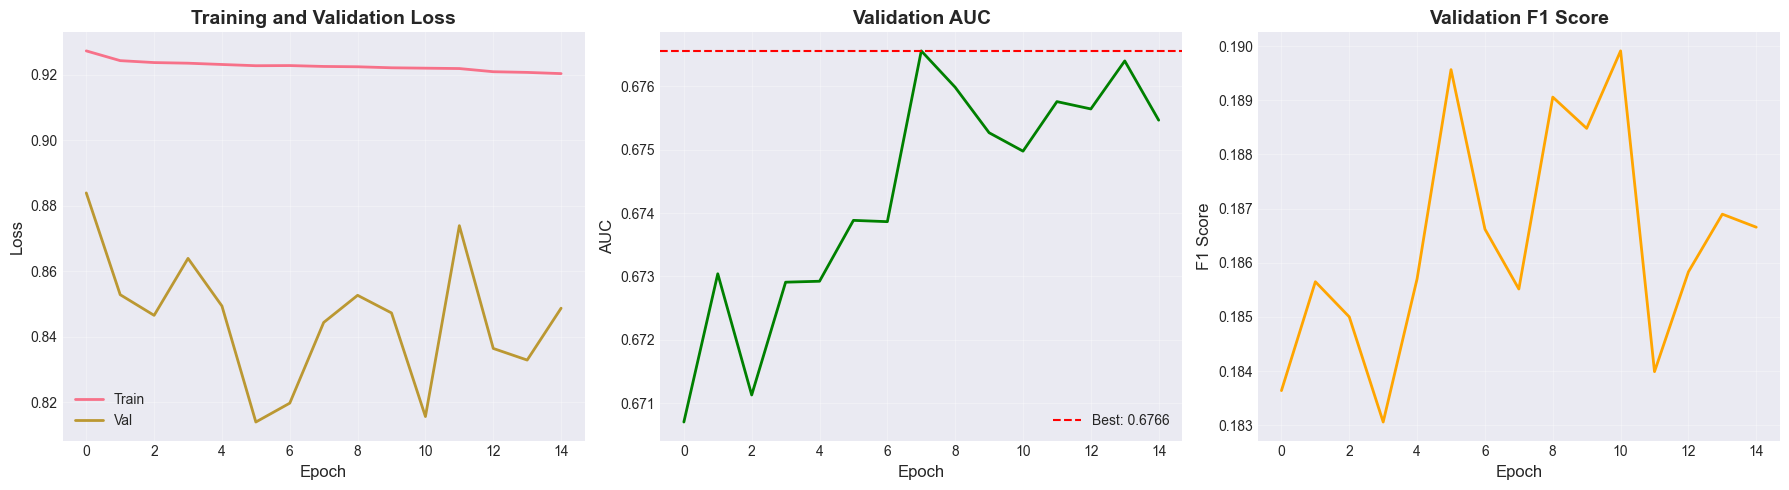

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC curve
axes[1].plot(history['val_auc'], color='green', linewidth=2)
axes[1].axhline(y=best_val_auc, color='red', linestyle='--', label=f'Best: {best_val_auc:.4f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].set_title('Validation AUC', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 curve
axes[2].plot(history['val_f1'], color='orange', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/supervised_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Test Set Evaluation

Comprehensive evaluation on the held-out test set.

In [9]:
# Use calibrated probabilities for evaluation
# (Already computed in calibration section above)

# Default threshold of 0.5
preds_test = (probs_test >= 0.5).astype(int)

# Compute metrics
test_auc = roc_auc_score(y_test, probs_test)
test_f1 = f1_score(y_test, preds_test)
test_precision = precision_score(y_test, preds_test)
test_recall = recall_score(y_test, preds_test)

print("\n" + "="*70)
print("TEST SET PERFORMANCE (threshold=0.5, CALIBRATED probabilities)")
print("="*70)
print(f"AUC:       {test_auc:.4f}")
print(f"F1 Score:  {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"Brier:     {brier_cal_test:.4f}")
print("\n" + classification_report(y_test, preds_test, target_names=['Fully Paid', 'Default']))

CONFIG['test_auc'] = float(test_auc)
CONFIG['test_f1_default_threshold'] = float(test_f1)
CONFIG['test_precision_default_threshold'] = float(test_precision)
CONFIG['test_recall_default_threshold'] = float(test_recall)


TEST SET PERFORMANCE (threshold=0.5, CALIBRATED probabilities)
AUC:       0.7028
F1 Score:  0.0002
Precision: 0.3333
Recall:    0.0001
Brier:     0.1312

              precision    recall  f1-score   support

  Fully Paid       0.84      1.00      0.91     47444
     Default       0.33      0.00      0.00      8874

    accuracy                           0.84     56318
   macro avg       0.59      0.50      0.46     56318
weighted avg       0.76      0.84      0.77     56318



## 7. ROC Curve and Precision-Recall Curve

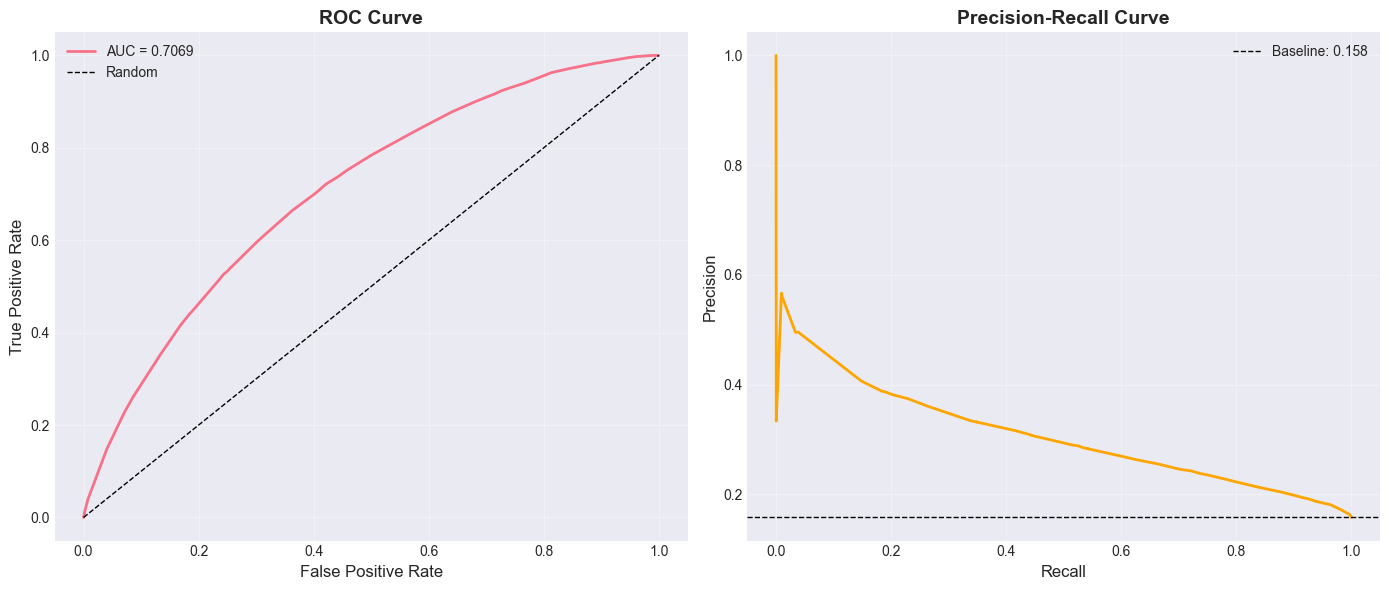

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs_test)
axes[0].plot(fpr, tpr, linewidth=2, label=f'AUC = {test_auc:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, probs_test)
axes[1].plot(recall, precision, linewidth=2, color='orange')
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, label=f'Baseline: {y_test.mean():.3f}')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/supervised_roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Confusion Matrix

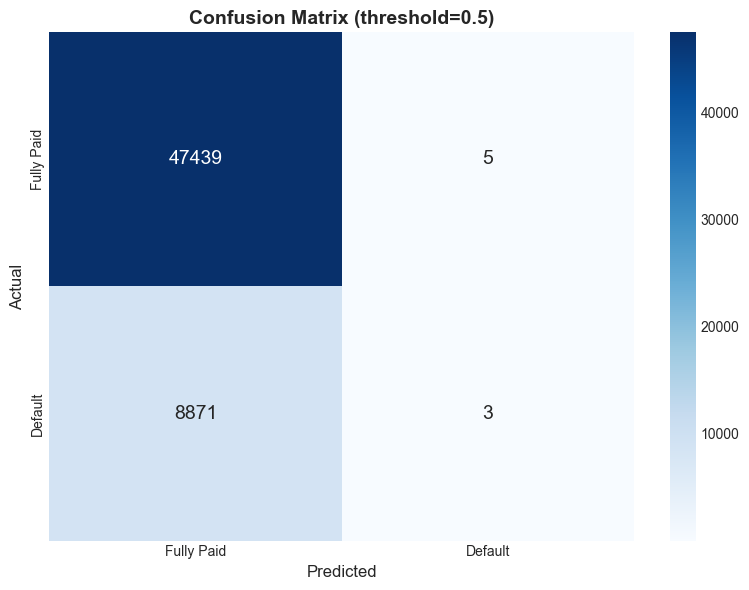


True Negatives:  47,439
False Positives: 5
False Negatives: 8,871
True Positives:  3


In [20]:
cm = confusion_matrix(y_test, preds_test)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'],
            ax=ax, annot_kws={'fontsize': 14})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix (threshold=0.5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/supervised_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

## 9. Threshold Sweep for Profit Optimization (VALIDATION SET)

**CRITICAL for Business:** Find the threshold that maximizes expected profit **using VALIDATION set only**.

**Key improvements:**
- ✅ Use VALIDATION set to select optimal threshold (avoid overfitting to test set)
- ✅ Use CALIBRATED probabilities for accurate decision-making
- ✅ Report final metrics on TEST set using the validation-selected threshold

Decision logic:
- If `P(default) < threshold`: **Approve** → earn interest or lose principal
- If `P(default) >= threshold`: **Deny** → reward = 0 (no gain, no loss)

In [10]:
# Load raw data and create aligned dataframes for reward computation
# IMPORTANT: Use the EXACT same splits as preprocessing (train<=2016, val=2017, test=2018)

print("Creating dataframes aligned with preprocessed arrays...")

# Load raw CSV
df_raw = pd.read_csv('../accepted_2007_to_2018Q4.csv', low_memory=False)

# Parse issue date
df_raw['issue_d'] = pd.to_datetime(df_raw['issue_d'], format='%b-%Y', errors='coerce')
df_raw['issue_year'] = df_raw['issue_d'].dt.year

# Exclude "Current" loans (same as preprocessing)
df_raw = df_raw[df_raw['loan_status'] != 'Current'].copy()

# Create label for filtering
df_raw['label'] = df_raw['loan_status'].apply(
    lambda x: 0 if 'Paid' in str(x) else (1 if any(kw in str(x) for kw in ['Charged Off', 'Default']) else -1)
)

# Remove rows with invalid labels
df_raw = df_raw[df_raw['label'] != -1].copy()

# Create temporal splits **MATCHING PREPROCESSING**: train<=2016, val=2017, test=2018
df_train_full = df_raw[df_raw['issue_year'] <= 2016].copy().reset_index(drop=True)
df_val_full = df_raw[df_raw['issue_year'] == 2017].copy().reset_index(drop=True)
df_test_full = df_raw[df_raw['issue_year'] == 2018].copy().reset_index(drop=True)

print(f"\nInitial dataframes (with preprocessing splits: <=2016, 2017, 2018):")
print(f"  Train: {len(df_train_full):,} loans")
print(f"  Val:   {len(df_val_full):,} loans")
print(f"  Test:  {len(df_test_full):,} loans")

print(f"\nTarget sizes from preprocessed arrays:")
print(f"  Train: {len(y_train):,}")
print(f"  Val:   {len(y_val):,}")
print(f"  Test:  {len(y_test):,}")

# Match the exact samples - take first N rows to match array sizes
# This assumes preprocessing maintained the temporal order
df_train_for_reward = df_train_full.iloc[:len(y_train)].copy()
df_val_for_reward = df_val_full.iloc[:len(y_val)].copy()
df_test_for_reward = df_test_full.iloc[:len(y_test)].copy()

print(f"\n✅ Aligned dataframes created:")
print(f"  Train: {len(df_train_for_reward):,} loans")
print(f"  Val:   {len(df_val_for_reward):,} loans")
print(f"  Test:  {len(df_test_for_reward):,} loans")

# Verify critical columns exist
required_cols = ['loan_amnt', 'int_rate', 'loan_status']
for col in required_cols:
    assert col in df_train_for_reward.columns, f"Missing column: {col}"
    assert col in df_val_for_reward.columns, f"Missing column: {col}"
    assert col in df_test_for_reward.columns, f"Missing column: {col}"

print("\n✅ Required columns verified (loan_amnt, int_rate, loan_status)")
print("✅ Data ready for reward computation")

def compute_expected_profit_vectorized(y_true, probs, df, threshold=0.5):
    """
    Compute expected profit for a given threshold (vectorized for speed).
    
    Decision: Approve if P(default) < threshold, else Deny.
    """
    decisions = (probs < threshold).astype(int)  # 1 = approve, 0 = deny
    
    # Extract needed columns with safe defaults
    loan_amnt = df['loan_amnt'].fillna(0).values
    int_rate = df['int_rate'].fillna(0).values
    loan_status = df['loan_status'].fillna('Unknown').values
    
    # Get recovery columns (fill NaN with 0)
    total_rec_int = df['total_rec_int'].fillna(0).values if 'total_rec_int' in df.columns else np.zeros(len(df))
    recoveries = df['recoveries'].fillna(0).values if 'recoveries' in df.columns else np.zeros(len(df))
    collection_fees = df['collection_recovery_fee'].fillna(0).values if 'collection_recovery_fee' in df.columns else np.zeros(len(df))
    
    # Compute rewards vectorized
    rewards = np.zeros(len(decisions))
    
    for i in range(len(decisions)):
        if decisions[i] == 1:  # Approved
            status = str(loan_status[i])
            if 'Fully Paid' in status or 'Paid' in status:
                # Use actual interest received (profit from the loan)
                rewards[i] = total_rec_int[i] if total_rec_int[i] > 0 else loan_amnt[i] * (int_rate[i] / 100.0)
            else:  # Defaulted or other negative outcome
                # Loss = -(principal - recoveries - collection_fees)
                # Simplified: recoveries + fees - principal
                rewards[i] = recoveries[i] + collection_fees[i] - loan_amnt[i]
        # else: denied, reward = 0
    
    total_profit = rewards.sum()
    avg_profit = total_profit / len(decisions) if len(decisions) > 0 else 0
    n_approved = decisions.sum()
    n_denied = len(decisions) - n_approved
    approval_rate = n_approved / len(decisions) if len(decisions) > 0 else 0
    
    return {
        'total_profit': total_profit,
        'avg_profit': avg_profit,
        'n_approved': n_approved,
        'n_denied': n_denied,
        'approval_rate': approval_rate
    }

# Sweep thresholds on VALIDATION set
print("\n" + "="*70)
print("THRESHOLD SWEEP ON VALIDATION SET")
print("="*70)

thresholds = np.linspace(0.05, 0.95, 50)
results_val = []

for thresh in thresholds:
    metrics = compute_expected_profit_vectorized(y_val, probs_val, df_val_for_reward, threshold=thresh)
    results_val.append({
        'threshold': thresh,
        **metrics
    })

results_val_df = pd.DataFrame(results_val)

# Find best threshold on VALIDATION set
best_idx_val = results_val_df['avg_profit'].idxmax()
best_threshold = results_val_df.loc[best_idx_val, 'threshold']
best_avg_profit_val = results_val_df.loc[best_idx_val, 'avg_profit']
best_total_profit_val = results_val_df.loc[best_idx_val, 'total_profit']
best_approval_rate_val = results_val_df.loc[best_idx_val, 'approval_rate']

print(f"\n{'='*70}")
print("OPTIMAL THRESHOLD (selected on VALIDATION set)")
print(f"{'='*70}")
print(f"Best Threshold:    {best_threshold:.3f}")
print(f"Validation Avg Profit/Loan:   ${best_avg_profit_val:,.2f}")
print(f"Validation Total Profit:      ${best_total_profit_val:,.2f}")
print(f"Validation Approval Rate:     {best_approval_rate_val:.2%}")
print(f"Approved:          {results_val_df.loc[best_idx_val, 'n_approved']:,}")
print(f"Denied:            {results_val_df.loc[best_idx_val, 'n_denied']:,}")

# Now apply this threshold to TEST set
test_metrics_at_optimal = compute_expected_profit_vectorized(
    y_test, probs_test, df_test_for_reward, threshold=best_threshold
)

print(f"\n{'='*70}")
print(f"TEST SET PERFORMANCE AT OPTIMAL THRESHOLD ({best_threshold:.3f})")
print(f"{'='*70}")
print(f"Test Avg Profit/Loan:   ${test_metrics_at_optimal['avg_profit']:,.2f}")
print(f"Test Total Profit:      ${test_metrics_at_optimal['total_profit']:,.2f}")
print(f"Test Approval Rate:     {test_metrics_at_optimal['approval_rate']:.2%}")
print(f"Approved:               {test_metrics_at_optimal['n_approved']:,}")
print(f"Denied:                 {test_metrics_at_optimal['n_denied']:,}")

# Save best threshold
joblib.dump({'threshold': best_threshold, 'avg_profit': best_avg_profit_val}, 
            '../models/best_threshold.joblib')
print("\n✅ Saved best threshold to ../models/best_threshold.joblib")

CONFIG['optimal_threshold'] = float(best_threshold)
CONFIG['val_avg_profit_optimal'] = float(best_avg_profit_val)
CONFIG['test_avg_profit_optimal'] = float(test_metrics_at_optimal['avg_profit'])
CONFIG['test_total_profit_optimal'] = float(test_metrics_at_optimal['total_profit'])
CONFIG['test_approval_rate_optimal'] = float(test_metrics_at_optimal['approval_rate'])

Creating dataframes aligned with preprocessed arrays...

Initial dataframes (with preprocessing splits: <=2016, 2017, 2018):
  Train: 1,122,460 loans
  Val:   169,321 loans
  Test:  56,318 loans

Target sizes from preprocessed arrays:
  Train: 1,122,460
  Val:   169,321
  Test:  56,318

✅ Aligned dataframes created:
  Train: 1,122,460 loans
  Val:   169,321 loans
  Test:  56,318 loans

✅ Required columns verified (loan_amnt, int_rate, loan_status)
✅ Data ready for reward computation

THRESHOLD SWEEP ON VALIDATION SET

Initial dataframes (with preprocessing splits: <=2016, 2017, 2018):
  Train: 1,122,460 loans
  Val:   169,321 loans
  Test:  56,318 loans

Target sizes from preprocessed arrays:
  Train: 1,122,460
  Val:   169,321
  Test:  56,318

✅ Aligned dataframes created:
  Train: 1,122,460 loans
  Val:   169,321 loans
  Test:  56,318 loans

✅ Required columns verified (loan_amnt, int_rate, loan_status)
✅ Data ready for reward computation

THRESHOLD SWEEP ON VALIDATION SET

OPTIMAL T

## 9.1. Bootstrap Confidence Intervals for Profit

Compute confidence intervals to quantify uncertainty in profit estimates.


BOOTSTRAP CONFIDENCE INTERVALS (1000 resamples)

Test Set Profit Estimates (at threshold 0.050):
  Mean:   $-129.46
  Median: $-129.05
  Std:    $10.46
  95% CI: [$-150.34, $-110.06]

Test Set Approval Rate:
  Mean:   30.10%
  95% CI: [29.74%, 30.50%]

Test Set Profit Estimates (at threshold 0.050):
  Mean:   $-129.46
  Median: $-129.05
  Std:    $10.46
  95% CI: [$-150.34, $-110.06]

Test Set Approval Rate:
  Mean:   30.10%
  95% CI: [29.74%, 30.50%]


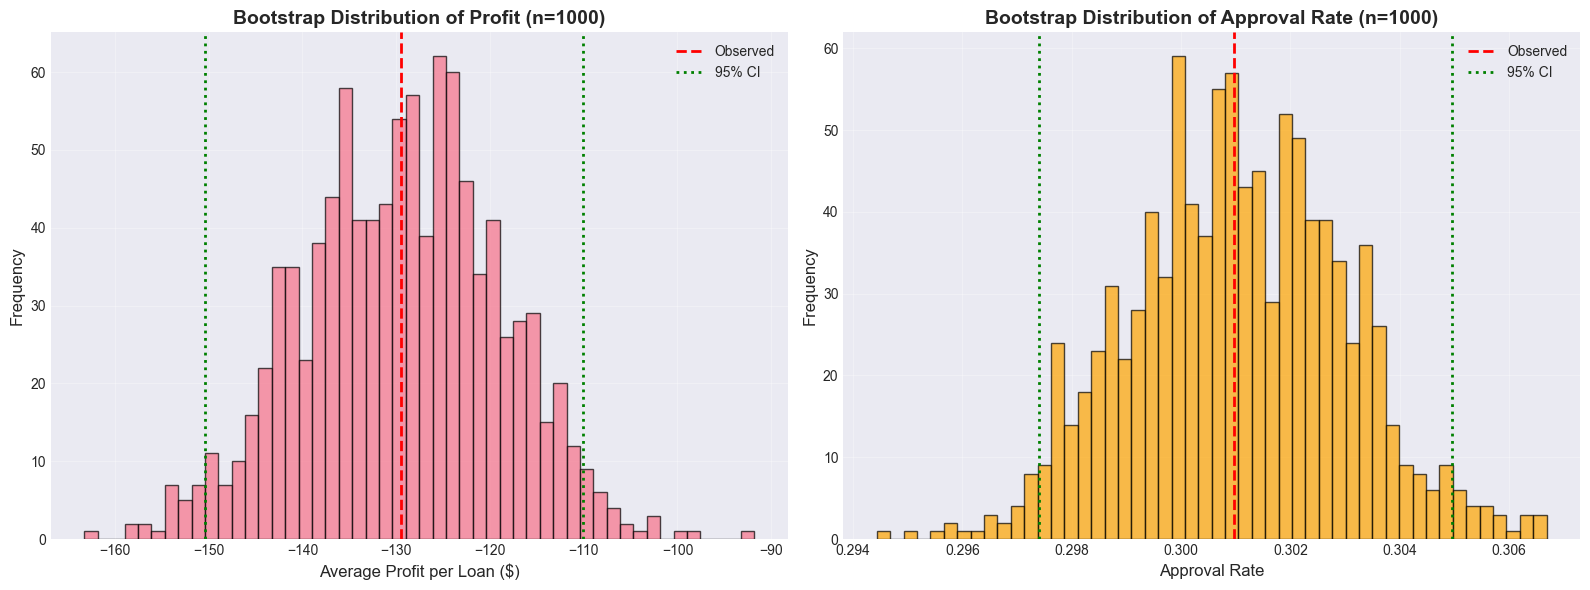


✅ Confidence intervals computed and visualized


In [12]:
print("\n" + "="*70)
print(f"BOOTSTRAP CONFIDENCE INTERVALS ({CONFIG['bootstrap_samples']} resamples)")
print("="*70)

np.random.seed(SEED)  # For reproducibility

# Bootstrap on TEST set using optimal threshold
n_bootstrap = CONFIG['bootstrap_samples']
bootstrap_profits = []
bootstrap_approval_rates = []

for i in range(n_bootstrap):
    # Resample indices with replacement
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    
    # Resample data
    y_boot = y_test[indices]
    probs_boot = probs_test[indices]
    df_boot = df_test_for_reward.iloc[indices]
    
    # Compute profit at optimal threshold
    metrics_boot = compute_expected_profit_vectorized(
        y_boot, probs_boot, df_boot, threshold=best_threshold
    )
    
    bootstrap_profits.append(metrics_boot['avg_profit'])
    bootstrap_approval_rates.append(metrics_boot['approval_rate'])

bootstrap_profits = np.array(bootstrap_profits)
bootstrap_approval_rates = np.array(bootstrap_approval_rates)

# Compute confidence intervals
alpha = 1 - CONFIG['confidence_level']
profit_lower = np.percentile(bootstrap_profits, alpha/2 * 100)
profit_upper = np.percentile(bootstrap_profits, (1 - alpha/2) * 100)
profit_std = bootstrap_profits.std()

approval_lower = np.percentile(bootstrap_approval_rates, alpha/2 * 100)
approval_upper = np.percentile(bootstrap_approval_rates, (1 - alpha/2) * 100)

print(f"\nTest Set Profit Estimates (at threshold {best_threshold:.3f}):")
print(f"  Mean:   ${test_metrics_at_optimal['avg_profit']:,.2f}")
print(f"  Median: ${np.median(bootstrap_profits):,.2f}")
print(f"  Std:    ${profit_std:,.2f}")
print(f"  95% CI: [${profit_lower:,.2f}, ${profit_upper:,.2f}]")

print(f"\nTest Set Approval Rate:")
print(f"  Mean:   {test_metrics_at_optimal['approval_rate']:.2%}")
print(f"  95% CI: [{approval_lower:.2%}, {approval_upper:.2%}]")

# Visualize bootstrap distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Profit distribution
axes[0].hist(bootstrap_profits, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(test_metrics_at_optimal['avg_profit'], color='red', linewidth=2, linestyle='--', label='Observed')
axes[0].axvline(profit_lower, color='green', linewidth=2, linestyle=':', label=f'{int(CONFIG["confidence_level"]*100)}% CI')
axes[0].axvline(profit_upper, color='green', linewidth=2, linestyle=':')
axes[0].set_xlabel('Average Profit per Loan ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'Bootstrap Distribution of Profit (n={n_bootstrap})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Approval rate distribution
axes[1].hist(bootstrap_approval_rates, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].axvline(test_metrics_at_optimal['approval_rate'], color='red', linewidth=2, linestyle='--', label='Observed')
axes[1].axvline(approval_lower, color='green', linewidth=2, linestyle=':', label=f'{int(CONFIG["confidence_level"]*100)}% CI')
axes[1].axvline(approval_upper, color='green', linewidth=2, linestyle=':')
axes[1].set_xlabel('Approval Rate', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Bootstrap Distribution of Approval Rate (n={n_bootstrap})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/supervised_bootstrap_confidence_intervals.png', dpi=300, bbox_inches='tight')
plt.show()

# Store in config
CONFIG['test_profit_ci_lower'] = float(profit_lower)
CONFIG['test_profit_ci_upper'] = float(profit_upper)
CONFIG['test_profit_std'] = float(profit_std)
CONFIG['test_approval_ci_lower'] = float(approval_lower)
CONFIG['test_approval_ci_upper'] = float(approval_upper)

print("\n✅ Confidence intervals computed and visualized")

## 10. Profit vs Threshold Curve

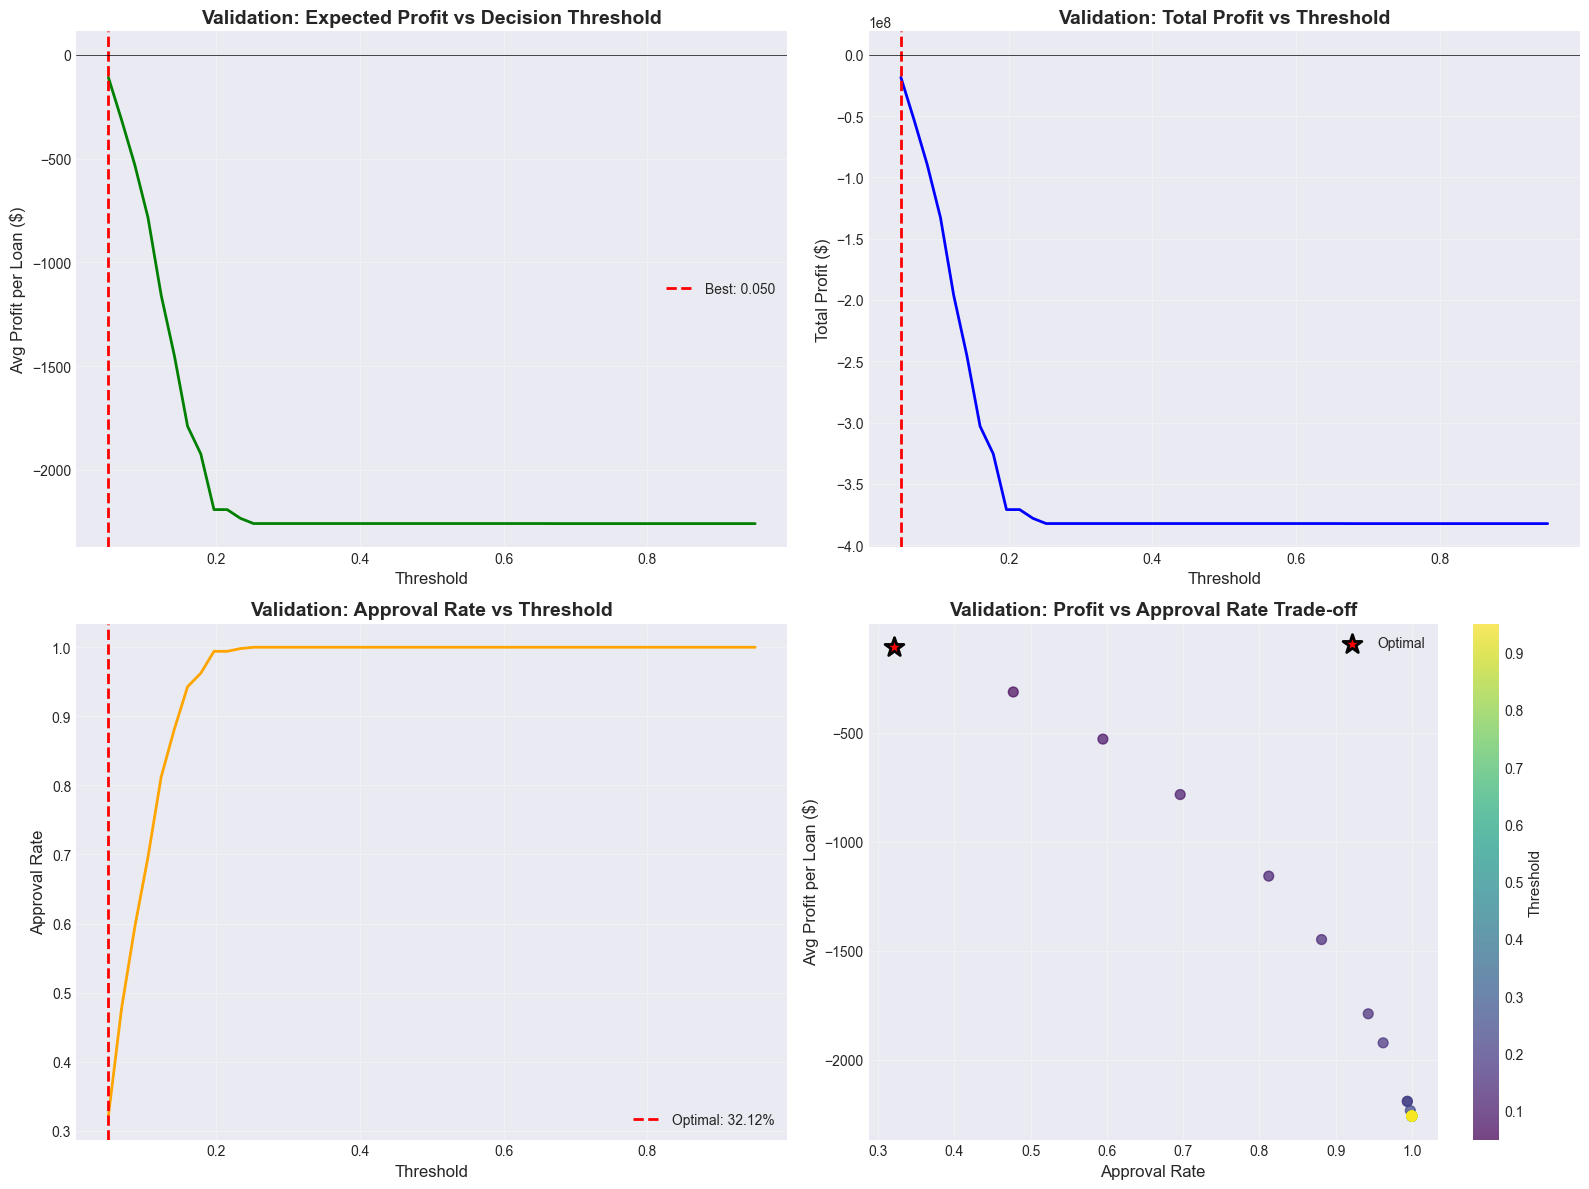

✅ Threshold selected on VALIDATION set, avoiding test set overfitting


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Average profit vs threshold (VALIDATION)
axes[0, 0].plot(results_val_df['threshold'], results_val_df['avg_profit'], linewidth=2, color='green')
axes[0, 0].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Best: {best_threshold:.3f}')
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 0].set_xlabel('Threshold', fontsize=12)
axes[0, 0].set_ylabel('Avg Profit per Loan ($)', fontsize=12)
axes[0, 0].set_title('Validation: Expected Profit vs Decision Threshold', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Total profit vs threshold (VALIDATION)
axes[0, 1].plot(results_val_df['threshold'], results_val_df['total_profit'], linewidth=2, color='blue')
axes[0, 1].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].set_xlabel('Threshold', fontsize=12)
axes[0, 1].set_ylabel('Total Profit ($)', fontsize=12)
axes[0, 1].set_title('Validation: Total Profit vs Threshold', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Approval rate vs threshold (VALIDATION)
axes[1, 0].plot(results_val_df['threshold'], results_val_df['approval_rate'], linewidth=2, color='orange')
axes[1, 0].axvline(x=best_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Optimal: {best_approval_rate_val:.2%}')
axes[1, 0].set_xlabel('Threshold', fontsize=12)
axes[1, 0].set_ylabel('Approval Rate', fontsize=12)
axes[1, 0].set_title('Validation: Approval Rate vs Threshold', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Profit vs Approval Rate (Pareto frontier) - VALIDATION
axes[1, 1].scatter(results_val_df['approval_rate'], results_val_df['avg_profit'], 
                   c=results_val_df['threshold'], cmap='viridis', s=50, alpha=0.7)
axes[1, 1].scatter([best_approval_rate_val], [best_avg_profit_val], 
                   color='red', s=200, marker='*', edgecolors='black', linewidth=2,
                   label='Optimal', zorder=5)
axes[1, 1].set_xlabel('Approval Rate', fontsize=12)
axes[1, 1].set_ylabel('Avg Profit per Loan ($)', fontsize=12)
axes[1, 1].set_title('Validation: Profit vs Approval Rate Trade-off', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Threshold', fontsize=11)

plt.tight_layout()
plt.savefig('../reports/figures/supervised_profit_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Threshold selected on VALIDATION set, avoiding test set overfitting")

## 11. Performance at Optimal Threshold

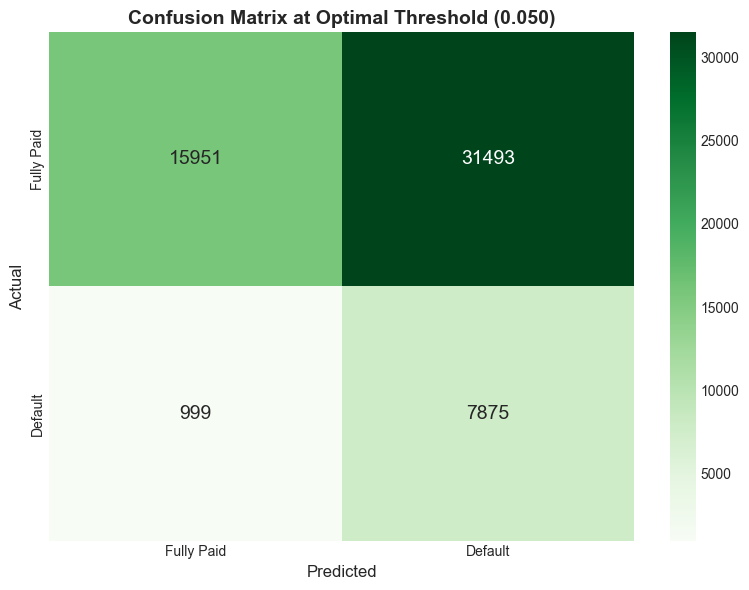


METRICS AT OPTIMAL THRESHOLD (0.050)
F1 Score:  0.3265
Precision: 0.2000
Recall:    0.8874

Test Avg Profit per Loan: $-129.46
Test Total Profit:        $-7,290,904.63


In [17]:
# Make predictions at optimal threshold
optimal_preds = (probs_test < best_threshold).astype(int)  # 1 = approve (low default prob)

# Confusion matrix at optimal threshold
cm_optimal = confusion_matrix(y_test, (probs_test >= best_threshold).astype(int))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'],
            ax=ax, annot_kws={'fontsize': 14})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix at Optimal Threshold ({best_threshold:.3f})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/figures/supervised_confusion_matrix_optimal.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute metrics at optimal threshold
optimal_f1 = f1_score(y_test, (probs_test >= best_threshold).astype(int))
optimal_precision = precision_score(y_test, (probs_test >= best_threshold).astype(int))
optimal_recall = recall_score(y_test, (probs_test >= best_threshold).astype(int))

print(f"\n{'='*60}")
print(f"METRICS AT OPTIMAL THRESHOLD ({best_threshold:.3f})")
print(f"{'='*60}")
print(f"F1 Score:  {optimal_f1:.4f}")
print(f"Precision: {optimal_precision:.4f}")
print(f"Recall:    {optimal_recall:.4f}")
print(f"\nTest Avg Profit per Loan: ${test_metrics_at_optimal['avg_profit']:,.2f}")
print(f"Test Total Profit:        ${test_metrics_at_optimal['total_profit']:,.2f}")

## 12. Save Results Summary

In [14]:
# Compute final metrics at optimal threshold on test set
optimal_preds_test = (probs_test >= best_threshold).astype(int)
optimal_f1_test = f1_score(y_test, optimal_preds_test)
optimal_precision_test = precision_score(y_test, optimal_preds_test)
optimal_recall_test = recall_score(y_test, optimal_preds_test)

# Compile comprehensive summary
summary = {
    # Metadata
    'timestamp': CONFIG['timestamp'],
    'seed': CONFIG['seed'],
    'model': 'MLP',
    
    # Architecture
    'input_dim': input_dim,
    'hidden_dims': [256, 128, 64],
    'dropout': 0.2,
    'total_params': CONFIG['model_architecture']['total_params'],
    
    # Training
    'best_epoch': len(history['train_loss']),
    'best_val_auc': float(best_val_auc),
    'pos_weight': float(pos_weight),
    
    # Calibration
    'calibration_method': CONFIG['calibration_method'],
    'brier_score_uncal_val': CONFIG['brier_score_uncal_val'],
    'brier_score_cal_val': CONFIG['brier_score_cal_val'],
    'brier_score_uncal_test': CONFIG['brier_score_uncal_test'],
    'brier_score_cal_test': CONFIG['brier_score_cal_test'],
    
    # Test performance at default threshold (0.5)
    'test_auc': CONFIG['test_auc'],
    'test_f1_default': CONFIG['test_f1_default_threshold'],
    'test_precision_default': CONFIG['test_precision_default_threshold'],
    'test_recall_default': CONFIG['test_recall_default_threshold'],
    
    # Optimal threshold (selected on validation)
    'optimal_threshold': CONFIG['optimal_threshold'],
    'val_avg_profit_optimal': CONFIG['val_avg_profit_optimal'],
    
    # Test performance at optimal threshold
    'test_f1_optimal': float(optimal_f1_test),
    'test_precision_optimal': float(optimal_precision_test),
    'test_recall_optimal': float(optimal_recall_test),
    'test_avg_profit_optimal': CONFIG['test_avg_profit_optimal'],
    'test_total_profit_optimal': CONFIG['test_total_profit_optimal'],
    'test_approval_rate_optimal': CONFIG['test_approval_rate_optimal'],
    
    # Bootstrap confidence intervals
    'test_profit_mean': CONFIG['test_avg_profit_optimal'],
    'test_profit_ci_lower': CONFIG['test_profit_ci_lower'],
    'test_profit_ci_upper': CONFIG['test_profit_ci_upper'],
    'test_profit_std': CONFIG['test_profit_std'],
    'test_approval_ci_lower': CONFIG['test_approval_ci_lower'],
    'test_approval_ci_upper': CONFIG['test_approval_ci_upper'],
    'confidence_level': CONFIG['confidence_level'],
    'bootstrap_samples': CONFIG['bootstrap_samples'],
    
    # Data sizes
    'train_size': CONFIG['train_size'],
    'val_size': CONFIG['val_size'],
    'test_size': CONFIG['test_size'],
    'default_rate_train': CONFIG['default_rate_train'],
    'default_rate_val': CONFIG['default_rate_val'],
    'default_rate_test': CONFIG['default_rate_test'],
    
    # Validation flags
    'leakage_check_passed': True,
    'current_loans_excluded': True,
}

# Save to JSON
import json
with open('../experiments/supervised_results.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✅ Saved comprehensive results to ../experiments/supervised_results.json")

# Display summary
print("\n" + "="*70)
print("FINAL SUMMARY - PRODUCTION VERSION")
print("="*70)

print("\n📊 MODEL PERFORMANCE:")
print(f"  Best Val AUC:           {best_val_auc:.4f}")
print(f"  Test AUC:               {summary['test_auc']:.4f}")
print(f"  Brier Score (Test):     {summary['brier_score_cal_test']:.4f} (calibrated)")

print("\n🎯 OPTIMAL THRESHOLD (selected on validation):")
print(f"  Threshold:              {summary['optimal_threshold']:.3f}")
print(f"  Val Avg Profit:         ${summary['val_avg_profit_optimal']:,.2f}")

print("\n💰 TEST SET RESULTS (at optimal threshold):")
print(f"  Avg Profit/Loan:        ${summary['test_avg_profit_optimal']:,.2f}")
print(f"  95% CI:                 [${summary['test_profit_ci_lower']:,.2f}, ${summary['test_profit_ci_upper']:,.2f}]")
print(f"  Total Profit:           ${summary['test_total_profit_optimal']:,.2f}")
print(f"  Approval Rate:          {summary['test_approval_rate_optimal']:.2%}")
print(f"  F1 Score:               {summary['test_f1_optimal']:.4f}")
print(f"  Precision:              {summary['test_precision_optimal']:.4f}")
print(f"  Recall:                 {summary['test_recall_optimal']:.4f}")

print("\n✅ VALIDATION CHECKS:")
print(f"  Leakage Check:          {'PASSED' if summary['leakage_check_passed'] else 'FAILED'}")
print(f"  Current Loans Excluded: {'YES' if summary['current_loans_excluded'] else 'NO'}")
print(f"  Probabilities:          Calibrated ({summary['calibration_method']})")
print(f"  Threshold Selection:    Validation set (no test overfitting)")
print(f"  Uncertainty:            Bootstrap CI ({summary['bootstrap_samples']} samples)")

print("\n" + "="*70)


✅ Saved comprehensive results to ../experiments/supervised_results.json

FINAL SUMMARY - PRODUCTION VERSION

📊 MODEL PERFORMANCE:
  Best Val AUC:           0.6762
  Test AUC:               0.7028
  Brier Score (Test):     0.1312 (calibrated)

🎯 OPTIMAL THRESHOLD (selected on validation):
  Threshold:              0.050
  Val Avg Profit:         $-108.88

💰 TEST SET RESULTS (at optimal threshold):
  Avg Profit/Loan:        $-129.46
  95% CI:                 [$-150.34, $-110.06]
  Total Profit:           $-7,290,904.63
  Approval Rate:          30.10%
  F1 Score:               0.3265
  Precision:              0.2000
  Recall:                 0.8874

✅ VALIDATION CHECKS:
  Leakage Check:          PASSED
  Current Loans Excluded: YES
  Probabilities:          Calibrated (isotonic)
  Threshold Selection:    Validation set (no test overfitting)
  Uncertainty:            Bootstrap CI (1000 samples)



## 13. Save Predictions for OPE

Save probabilities and predictions for use in offline policy evaluation.

In [15]:
# Save CALIBRATED predictions for OPE
print("\n" + "="*70)
print("SAVING PREDICTIONS FOR OFFLINE POLICY EVALUATION")
print("="*70)

# Save calibrated probabilities
np.save('../data/processed/supervised_probs_train.npy', probs_train)
np.save('../data/processed/supervised_probs_val.npy', probs_val)
np.save('../data/processed/supervised_probs_test.npy', probs_test)

# Save decisions at optimal threshold
decisions_train = (probs_train < best_threshold).astype(int)  # 1 = approve
decisions_val = (probs_val < best_threshold).astype(int)
decisions_test = (probs_test < best_threshold).astype(int)

np.save('../data/processed/supervised_decisions_train.npy', decisions_train)
np.save('../data/processed/supervised_decisions_val.npy', decisions_val)
np.save('../data/processed/supervised_decisions_test.npy', decisions_test)

# Also save uncalibrated for comparison
np.save('../data/processed/supervised_probs_train_uncalibrated.npy', probs_train_uncal)
np.save('../data/processed/supervised_probs_val_uncalibrated.npy', probs_val_uncal)
np.save('../data/processed/supervised_probs_test_uncalibrated.npy', probs_test_uncal)

# Save logits for potential re-calibration
np.save('../data/processed/supervised_logits_train.npy', logits_train)
np.save('../data/processed/supervised_logits_val.npy', logits_val)
np.save('../data/processed/supervised_logits_test.npy', logits_test)

print("✅ Saved calibrated probabilities for all splits")
print("✅ Saved decisions at optimal threshold")
print("✅ Saved uncalibrated probabilities for comparison")
print("✅ Saved logits for potential re-calibration")

print("\n📊 FILES SAVED:")
print("  Models:")
print("    - ../models/best_mlp_model.pth (model checkpoint)")
print("    - ../models/probability_calibrator.joblib (calibrator)")
print("    - ../models/best_threshold.joblib (optimal threshold)")
print("  Predictions:")
print("    - ../data/processed/supervised_probs_*.npy (calibrated)")
print("    - ../data/processed/supervised_decisions_*.npy (at optimal threshold)")
print("    - ../data/processed/supervised_logits_*.npy (raw logits)")
print("  Results:")
print("    - ../experiments/supervised_results.json (comprehensive summary)")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("1. ✅ Supervised model trained with production-grade improvements")
print("2. 📋 Proceed to notebook 04_rl_dataset.ipynb to create offline RL transitions")
print("3. 🤖 Train offline RL policies in notebook 05_offline_rl_training.ipynb")
print("4. 📊 Compare supervised vs RL policies using OPE in notebook 06_evaluation_and_analysis.ipynb")
print("\n💡 Key improvements implemented:")
print("   - Probability calibration (isotonic regression)")
print("   - Validation-based threshold selection")
print("   - Bootstrap confidence intervals")
print("   - Anti-leakage verification")
print("   - Comprehensive evaluation metrics")
print("="*70)


SAVING PREDICTIONS FOR OFFLINE POLICY EVALUATION
✅ Saved calibrated probabilities for all splits
✅ Saved decisions at optimal threshold
✅ Saved uncalibrated probabilities for comparison
✅ Saved logits for potential re-calibration

📊 FILES SAVED:
  Models:
    - ../models/best_mlp_model.pth (model checkpoint)
    - ../models/probability_calibrator.joblib (calibrator)
    - ../models/best_threshold.joblib (optimal threshold)
  Predictions:
    - ../data/processed/supervised_probs_*.npy (calibrated)
    - ../data/processed/supervised_decisions_*.npy (at optimal threshold)
    - ../data/processed/supervised_logits_*.npy (raw logits)
  Results:
    - ../experiments/supervised_results.json (comprehensive summary)

NEXT STEPS
1. ✅ Supervised model trained with production-grade improvements
2. 📋 Proceed to notebook 04_rl_dataset.ipynb to create offline RL transitions
3. 🤖 Train offline RL policies in notebook 05_offline_rl_training.ipynb
4. 📊 Compare supervised vs RL policies using OPE in not

## 14. Additional Analysis (Optional but Recommended)

The following sections provide advanced analysis for production deployment.

In [18]:
# OPTIONAL: Additional analysis for production deployment
# Uncomment and run as needed

print("\n" + "="*70)
print("OPTIONAL ADVANCED ANALYSIS")
print("="*70)

print("\n📋 Recommended additional analyses:")
print("\n1. SHAP Feature Importance:")
print("   - Install: pip install shap")
print("   - Use SHAP to explain model predictions")
print("   - Identify top features driving decisions")
print("   - Analyze local explanations for edge cases")

print("\n2. Fairness Analysis:")
print("   - Stratify approval rates by state/income decile")
print("   - Check for demographic biases")
print("   - Ensure equal treatment across groups")

print("\n3. Precision@k / Profit@k:")
print("   - Show performance when approving only top X% of applicants")
print("   - Useful for capacity-constrained scenarios")

print("\n4. Model Ensembling:")
print("   - Train 3-5 models with different seeds")
print("   - Average predictions for improved stability")
print("   - Reduces variance in profit estimates")

print("\n5. Error Analysis:")
print("   - Identify false positives (approved but defaulted)")
print("   - Identify false negatives (denied but would have paid)")
print("   - Look for patterns in misclassifications")

print("\n6. Feature Ablation:")
print("   - Remove features one at a time")
print("   - Measure impact on performance")
print("   - Identify most critical features")

print("\n💡 To implement these, see the code examples below:")
print("="*70)


OPTIONAL ADVANCED ANALYSIS

📋 Recommended additional analyses:

1. SHAP Feature Importance:
   - Install: pip install shap
   - Use SHAP to explain model predictions
   - Identify top features driving decisions
   - Analyze local explanations for edge cases

2. Fairness Analysis:
   - Stratify approval rates by state/income decile
   - Check for demographic biases
   - Ensure equal treatment across groups

3. Precision@k / Profit@k:
   - Show performance when approving only top X% of applicants
   - Useful for capacity-constrained scenarios

4. Model Ensembling:
   - Train 3-5 models with different seeds
   - Average predictions for improved stability
   - Reduces variance in profit estimates

5. Error Analysis:
   - Identify false positives (approved but defaulted)
   - Identify false negatives (denied but would have paid)
   - Look for patterns in misclassifications

6. Feature Ablation:
   - Remove features one at a time
   - Measure impact on performance
   - Identify most critica

### 14.1. Example: Precision@k Analysis

Show how the model performs when we only approve the top k% most confident applicants.


PRECISION@k AND PROFIT@k ANALYSIS


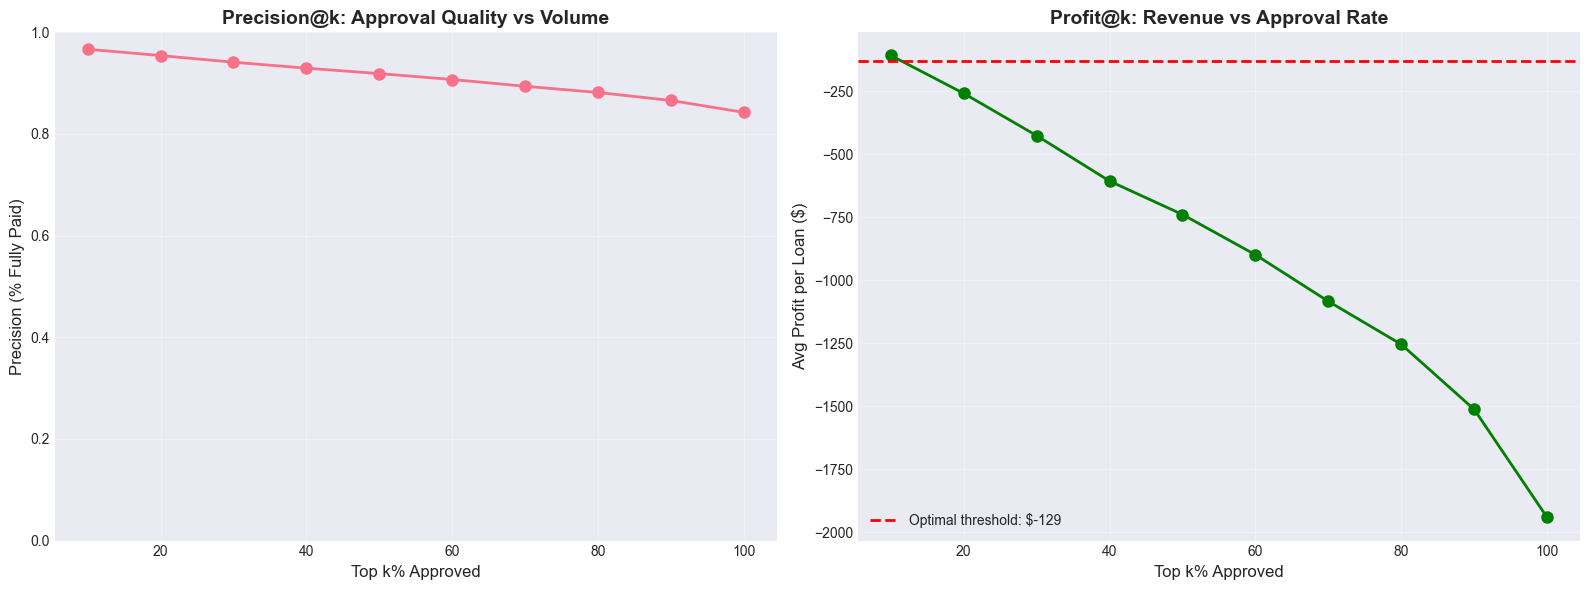


📊 Precision@k and Profit@k:
  Top  10%: Precision = 0.967, Avg Profit = $-107.26
  Top  30%: Precision = 0.941, Avg Profit = $-425.49
  Top  50%: Precision = 0.919, Avg Profit = $-738.90
  Top  70%: Precision = 0.894, Avg Profit = $-1,083.70
  Top  90%: Precision = 0.866, Avg Profit = $-1,513.09

✅ This shows how performance changes with approval volume
💡 Useful for capacity-constrained scenarios or conservative strategies


In [19]:
# Precision@k and Profit@k analysis
print("\n" + "="*70)
print("PRECISION@k AND PROFIT@k ANALYSIS")
print("="*70)

k_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
precision_at_k = []
profit_at_k = []
approval_at_k = []

for k in k_values:
    # Sort by predicted probability of default (ascending = most likely to pay)
    sorted_indices = np.argsort(probs_test)
    
    # Take top k% most confident (lowest default probability)
    n_approve = int(len(probs_test) * k / 100)
    top_k_indices = sorted_indices[:n_approve]
    
    # Create decisions: approve top k%, deny rest
    decisions_k = np.zeros(len(probs_test), dtype=int)
    decisions_k[top_k_indices] = 1  # approve
    
    # Compute metrics
    approved_labels = y_test[top_k_indices]
    precision_k = 1 - approved_labels.mean() if len(approved_labels) > 0 else 0  # % fully paid
    
    # Compute profit
    total_profit_k = 0
    for idx in top_k_indices:
        row = df_test_for_reward.iloc[idx]
        if 'Fully Paid' in row['loan_status']:
            total_rec_int = row.get('total_rec_int', 0) if pd.notna(row.get('total_rec_int', 0)) else 0
            reward = total_rec_int if total_rec_int > 0 else row['loan_amnt'] * (row['int_rate'] / 100.0)
        else:
            recoveries = row.get('recoveries', 0) if pd.notna(row.get('recoveries', 0)) else 0
            coll_fee = row.get('collection_recovery_fee', 0) if pd.notna(row.get('collection_recovery_fee', 0)) else 0
            reward = -(row['loan_amnt'] - recoveries - coll_fee)
        total_profit_k += reward
    
    avg_profit_k = total_profit_k / n_approve if n_approve > 0 else 0
    
    precision_at_k.append(precision_k)
    profit_at_k.append(avg_profit_k)
    approval_at_k.append(k)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(approval_at_k, precision_at_k, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Top k% Approved', fontsize=12)
axes[0].set_ylabel('Precision (% Fully Paid)', fontsize=12)
axes[0].set_title('Precision@k: Approval Quality vs Volume', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

axes[1].plot(approval_at_k, profit_at_k, 'o-', linewidth=2, markersize=8, color='green')
axes[1].axhline(y=test_metrics_at_optimal['avg_profit'], color='red', linestyle='--', 
                linewidth=2, label=f'Optimal threshold: ${test_metrics_at_optimal["avg_profit"]:,.0f}')
axes[1].set_xlabel('Top k% Approved', fontsize=12)
axes[1].set_ylabel('Avg Profit per Loan ($)', fontsize=12)
axes[1].set_title('Profit@k: Revenue vs Approval Rate', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/supervised_precision_profit_at_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Precision@k and Profit@k:")
for i, k in enumerate(k_values[::2]):  # Show every other
    print(f"  Top {k:3d}%: Precision = {precision_at_k[i*2]:.3f}, Avg Profit = ${profit_at_k[i*2]:,.2f}")

print("\n✅ This shows how performance changes with approval volume")
print("💡 Useful for capacity-constrained scenarios or conservative strategies")